In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from scipy.optimize import minimize_scalar
from tqdm.notebook import tqdm

def utility(flex, limit, demand, flex_cost=0.1, overdraw_cost=1):
    '''
    Simple utility function that takes into account the possibility to buy too little flex.
    NOTE: This is unrealistic in that we can not buy a real number of flex in practice.
    '''
    effective_demand = demand - flex # Are we above despide having flex?
    effective_above = effective_demand > limit 
    above = demand > limit # Would we have been above if we did not buy flex?
    if effective_above: # Even with flex, we are above the limit
        u = - overdraw_cost * (effective_demand - limit) - flex_cost * flex
    elif above: # We would have been over the limit if we had not had flex.
        u = overdraw_cost * (demand - limit) - flex_cost * flex
    else: # We are below no matter what.
        u = - flex_cost * flex
    return float(u)

In [4]:
lstm_data = 'lstm_quantile_regression.txt'

df_qr = pd.read_csv(lstm_data, parse_dates=True)
df_qr.index = pd.to_datetime(df_qr['timestamp_forecast'])
df_qr.timestamp_start = pd.to_datetime(df_qr.timestamp_start)
df_qr.timestamp_forecast = pd.to_datetime(df_qr.timestamp_forecast)

In [5]:
limit = 40
df_quantiles = df_qr.drop(columns=['station', 'timestamp_start', 'timestamp_forecast', 'true_target'])
df_quantiles.columns = sorted(df_quantiles.columns, key=lambda x: float(x[1:]))
sorted_columns = sorted(df_quantiles.columns, key=lambda x: float(x[1:]))
df_quantiles.columns = [float(col[1:]) for col in sorted_columns]

# Apply isontonic regression to get proper quantiles
ir = IsotonicRegression()
for i, row in df_quantiles.iterrows():
    ir.fit(df_quantiles.columns, row.values)
    row[row.index] = ir.predict(df_quantiles.columns)

In [6]:
# TODO: Check this one carefully. It really needs to be correct!
def integrate_step_function_with_jumps(func, jump_points, a, b):
    """
    Integrates a step function given its jump points.

    Args:
        func: The step function (callable).
        jump_points: A sorted list of the x-coordinates of the jump points.
        a: The lower bound of the integration interval.
        b: The upper bound of the integration interval.

    Returns:
        The exact integral of the step function over [a, b].
    """

    integral = 0.0
    current_x = a

    # Handle the case where 'a' is before the first jump point
    current_y = func(current_x)

    for jump_point in jump_points:
        if current_x >= b: # We've finished integration
            break
        next_x = min(jump_point, b)  # Don't overshoot 'b'
        integral += current_y * (next_x - current_x)
        current_x = next_x
        if current_x == b: # We've finished integration
            break
        current_y = func(current_x) # Function value after jump

    # Handle the last segment (from the last jump point or 'a' to 'b')
    next_x = b
    integral += current_y * (next_x - current_x)

    return integral

jump_points = df_quantiles.columns.values  # The x-coordinates where the function changes

In [7]:
from scipy.interpolate import interp1d

idx = 152

# Define the quantile values
quantiles = np.zeros(101)
quantiles[1:-1] = df_quantiles.iloc[idx]
quantiles[0] = 0
quantiles[-1] = 50

# Define the probability levels corresponding to the quantiles
p = np.zeros(101)  # Evenly spaced probabilities
p[1:-1] = df_quantiles.columns
p[0] = 0.0
p[-1] = 1.0

# Define the step function for the quantile function
quantile_function = interp1d(p, quantiles, kind='previous', fill_value=(quantiles[0], quantiles[-1]), bounds_error=False)

In [8]:
exp_util = lambda d: integrate_step_function_with_jumps(lambda p: utility(flex=d, limit=limit, demand=quantile_function(p)), jump_points, 0, 1)
optimiser_decision = minimize_scalar(lambda d: -exp_util(d), bounds=(0,10)).x
optimiser_decision

6.342340983203779

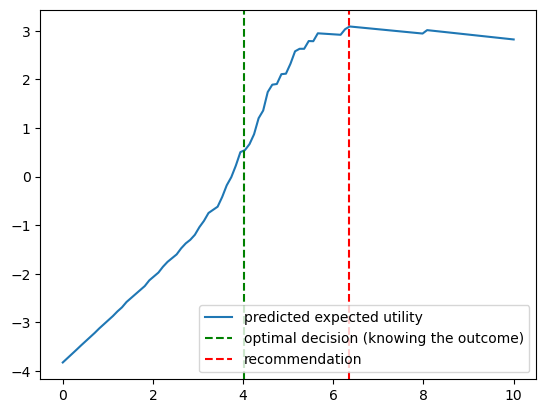

In [9]:
D = np.linspace(0, 10, num=100)
plt.plot(
    D,
    [exp_util(d) for d in D],
    label='predicted expected utility'
)
opt = df_qr.iloc[idx].true_target - limit
if opt > 0:
    plt.axvline(opt, linestyle='--', color='green', label='optimal decision (knowing the outcome)')
plt.axvline(optimiser_decision, linestyle='--', color='red', label='recommendation')
plt.legend()

In [10]:
y = df_qr.iloc[idx].true_target
y

44.01859876365661

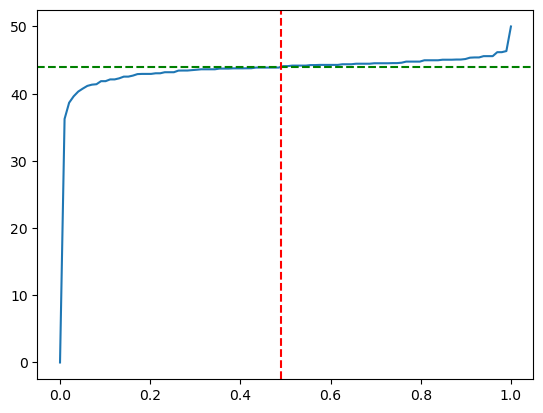

In [11]:
plt.plot(
    np.linspace(0, 1, num=100),
    [quantile_function(p) for p in np.linspace(0, 1, num=100)],
)
plt.axhline(y, linestyle='--', color='green', label='true target')
from scipy.optimize import brentq
sol = brentq(lambda p: quantile_function(p) - y, 0, 1)
plt.axvline(sol, linestyle='--', color='red', label='true quantile')

In [12]:
from scipy.optimize import brentq
brentq(lambda p: quantile_function(p) - y, 0, 1)

0.49000000000090943

Now loop over all rows and make decisions

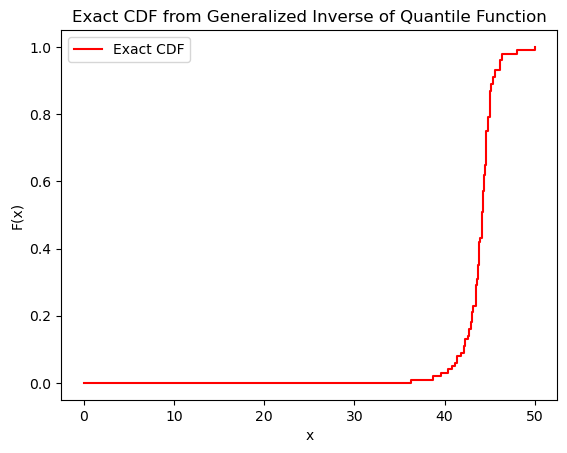

In [13]:
import numpy as np

# Sort unique quantiles and associated probabilities
unique_x, unique_p = np.unique(quantiles, return_index=True)
sorted_p = p[unique_p]

# Define exact generalized inverse (right-continuous)
def exact_cdf(x):
    return sorted_p[np.searchsorted(unique_x, x, side='right') - 1]

# Example usage
x_values = np.linspace(0, 2*limit, 100)
cdf_values = np.array([exact_cdf(x) for x in x_values])

# Plot the exact CDF
import matplotlib.pyplot as plt
plt.step(unique_x, sorted_p, where="post", label="Exact CDF", color="red")
plt.xlabel("x")
plt.ylabel("F(x)")
plt.title("Exact CDF from Generalized Inverse of Quantile Function")
plt.legend()
plt.show()


In [14]:
def check_calibration(idx):
    # Define the quantile values
    quantiles = np.zeros(101)
    quantiles[1:-1] = df_quantiles.iloc[idx]
    quantiles[0] = 0
    quantiles[-1] = 50

    # Define the probability levels corresponding to the quantiles
    p = np.zeros(101)  # Evenly spaced probabilities
    p[1:-1] = df_quantiles.columns
    p[0] = 0.0
    p[-1] = 1.0

    # Sort unique quantiles and associated probabilities
    unique_x, unique_p = np.unique(quantiles, return_index=True)
    sorted_p = p[unique_p]

    # Define exact generalized inverse (right-continuous)
    def exact_cdf(x):
        return sorted_p[np.searchsorted(unique_x, x, side='right') - 1]
    
    y = df_qr.iloc[idx].true_target

    return exact_cdf(y)

In [15]:
pit = np.zeros(df_quantiles.shape[0])

for idx in tqdm(range(df_quantiles.shape[0])):
    pit[idx] = check_calibration(idx)

  0%|          | 0/2130 [00:00<?, ?it/s]

In [25]:
def check_protected_calibration(idx, B):
    # Define the quantile values
    quantiles = np.zeros(101)
    quantiles[1:-1] = df_quantiles.iloc[idx]
    quantiles[0] = 0
    quantiles[-1] = 50

    # Define the probability levels corresponding to the quantiles
    p = np.zeros(101)  # Evenly spaced probabilities
    p[1:-1] = df_quantiles.columns
    p[0] = 0.0
    p[-1] = 1.0

    # Sort unique quantiles and associated probabilities
    unique_x, unique_p = np.unique(quantiles, return_index=True)
    sorted_p = p[unique_p]

    # Define exact generalized inverse (right-continuous)
    def exact_cdf(x):
        return sorted_p[np.searchsorted(unique_x, x, side='right') - 1]
    
    y = df_qr.iloc[idx].true_target

    return B(exact_cdf(y))

In [26]:
protected_pit = np.zeros(df_quantiles.shape[0])
from online_cp import PluginMartingale
martingale = PluginMartingale(warnings=False)
for idx in tqdm(range(df_quantiles.shape[0])):
    p = check_protected_calibration(idx, martingale.B_n)
    protected_pit[idx] = p
    martingale.update_martingale_value(p)

  0%|          | 0/2130 [00:00<?, ?it/s]

(array([1.04573005, 1.06465729, 0.94636204, 0.96055747, 0.95582566,
        0.92270299, 0.93216661, 0.86592127, 1.01260738, 1.37222496]),
 array([0.        , 0.0992186 , 0.19843719, 0.29765579, 0.39687439,
        0.49609298, 0.59531158, 0.69453018, 0.79374877, 0.89296737,
        0.99218597]),
 <BarContainer object of 10 artists>)

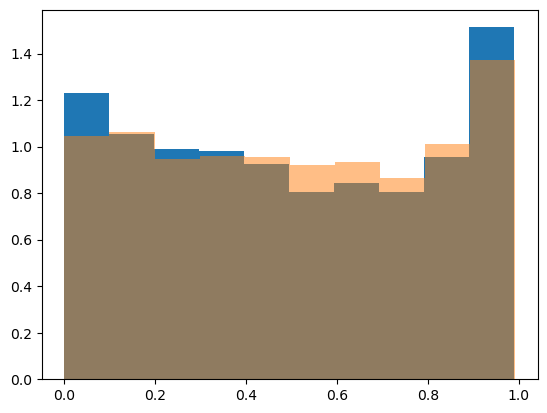

In [27]:
plt.hist(pit, density=True)
plt.hist(protected_pit, density=True, alpha=0.5)

In [8]:
def make_decision(idx):
    # Define the quantile values
    quantiles = np.zeros(101)
    quantiles[1:-1] = df_quantiles.iloc[idx]
    quantiles[0] = 0
    quantiles[-1] = 50

    # Define the probability levels corresponding to the quantiles
    p = np.zeros(101)  # Evenly spaced probabilities
    p[1:-1] = df_quantiles.columns
    p[0] = 0.0
    p[-1] = 1.0

    # Define the step function for the quantile function
    quantile_function = interp1d(p, quantiles, kind='previous', fill_value=(quantiles[0], quantiles[-1]), bounds_error=False)

    exp_util = lambda d: integrate_step_function_with_jumps(lambda p: utility(flex=d, limit=limit, demand=quantile_function(p)), jump_points, 0, 1)
    optimiser_decision = minimize_scalar(lambda d: -exp_util(d), bounds=(0,10)).x

    optimal_d = max(df_qr.iloc[idx].true_target - limit, 0)

    return optimiser_decision, optimal_d

In [9]:
decisions = np.zeros(df_quantiles.shape[0])
optimal_decisions = np.zeros_like(decisions)

for idx in tqdm(range(df_quantiles.shape[0])):
    d, optimal_d = make_decision(idx)
    decisions[idx] = d
    optimal_decisions[idx] = optimal_d

  0%|          | 0/2130 [00:00<?, ?it/s]

In [59]:
base_decisions = (df_qr.drop(columns=['station', 'timestamp_start', 'timestamp_forecast', 'true_target'])['p0.95'] - limit).clip(lower=0).values

isotonic_decisions = (df_quantiles[0.95] - limit).clip(lower=0).values

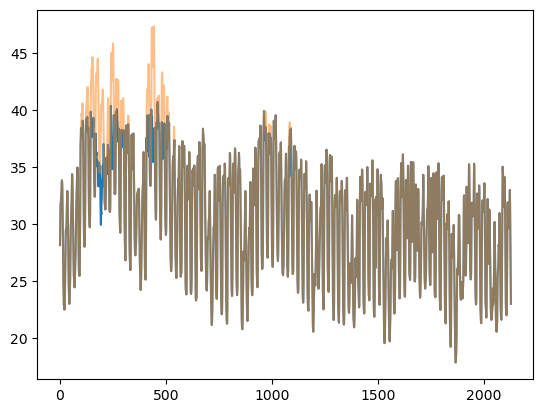

In [60]:
plt.plot(df_qr.true_target.values - decisions)
plt.plot(df_qr.true_target.values, alpha=0.5)

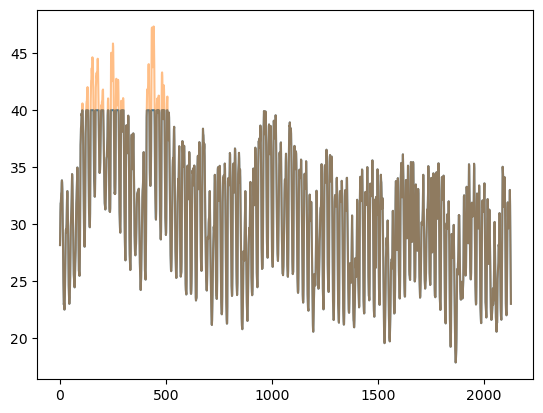

In [61]:
plt.plot(df_qr.true_target.values - optimal_decisions)
plt.plot(df_qr.true_target.values, alpha=0.5)

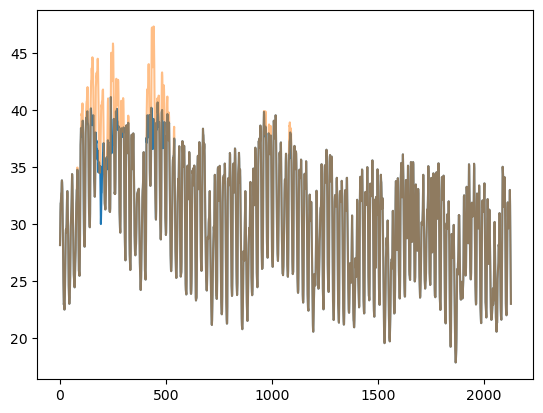

In [62]:
plt.plot(df_qr.true_target.values - base_decisions)
plt.plot(df_qr.true_target.values, alpha=0.5)

In [63]:
(df_qr.true_target.values - decisions).max() - limit, (df_qr.true_target.values - base_decisions).max() - limit

(np.float64(0.7239990536007141), np.float64(1.1574837118804382))

In [55]:
(df_qr.true_target.values - decisions > limit).sum(), (df_qr.true_target.values - base_decisions > limit).sum()

(np.int64(5), np.int64(6))

In [64]:
Utility = np.zeros_like(decisions)
for i, (d, demand) in enumerate(zip(decisions, df_qr.true_target.values)):
    Utility[i] = utility(d, limit, demand)

optimal_Utility = np.zeros_like(decisions)
for i, (d, demand) in enumerate(zip(optimal_decisions, df_qr.true_target.values)):
    optimal_Utility[i] = utility(d, limit, demand)

base_Utility = np.zeros_like(decisions)
for i, (d, demand) in enumerate(zip(base_decisions, df_qr.true_target.values)):
    base_Utility[i] = utility(d, limit, demand)

isotonic_Utility = np.zeros_like(decisions)
for i, (d, demand) in enumerate(zip(isotonic_decisions, df_qr.true_target.values)):
    isotonic_Utility[i] = utility(d, limit, demand)

In [65]:
Utility.sum(), optimal_Utility.sum(), isotonic_Utility.sum(), base_Utility.sum()

(np.float64(231.88001191694656),
 np.float64(287.11107635699057),
 np.float64(238.53515157164497),
 np.float64(229.273831191903))

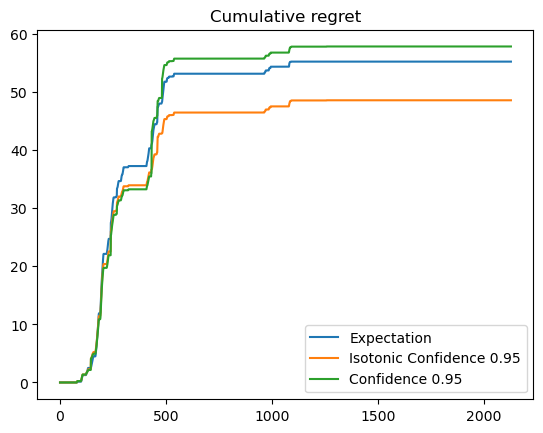

In [68]:
Regret = optimal_Utility - Utility
base_Regret = optimal_Utility - base_Utility
isotonic_Regret = optimal_Utility - isotonic_Utility
plt.plot(Regret.cumsum(), label='Expectation')
plt.plot(isotonic_Regret.cumsum(), label=f'Isotonic Confidence {0.95}')
plt.plot(base_Regret.cumsum(), label=f'Confidence {0.95}')
plt.title('Cumulative regret')
plt.legend()

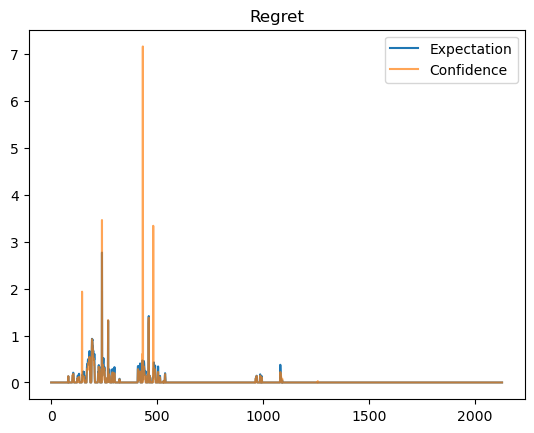

In [19]:
plt.plot(Regret, label='Expectation')
plt.plot(base_Regret, label='Confidence', alpha=0.7)
plt.title('Regret')
plt.legend()

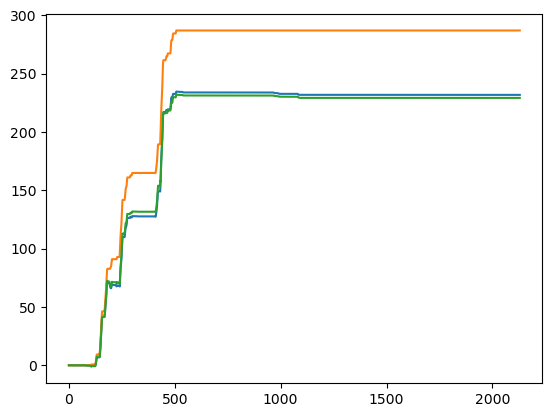

In [20]:
plt.plot(Utility.cumsum())
plt.plot(optimal_Utility.cumsum())
plt.plot(base_Utility.cumsum())

# Figure out PIT
We should be able to invert. Not crucial, but nice to have.

Calibration plot may suffice.

In [21]:
calibration = np.zeros(shape=(100, 2))
for i, q in enumerate(np.linspace(0.01, 1, 100, endpoint=False)[::-1]):
    quantile = f'p{np.round(q,2)}'
    calibration[i, 1] = ((df_qr.true_target > df_qr[quantile]).mean())
    quantile = np.round(q,2)
    calibration[i, 0] = ((df_qr.true_target > df_quantiles[quantile]).mean())

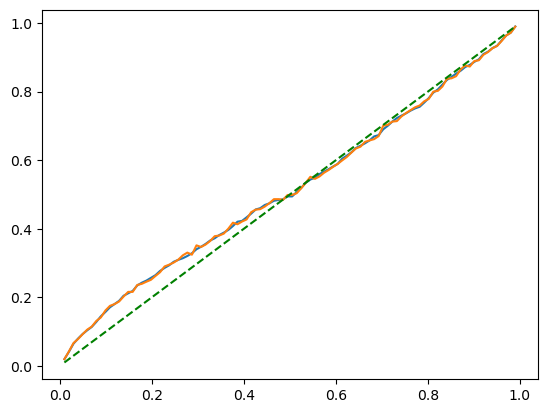

In [22]:
plt.plot(np.linspace(0.01, 1, 100, endpoint=False), calibration[:, 0])
plt.plot(np.linspace(0.01, 1, 100, endpoint=False), calibration[:, 1])
plt.plot(np.linspace(0.01, 1, 100, endpoint=False), np.linspace(0.01, 1, 100, endpoint=False), linestyle='--', color='green')

# Plan
The protection procedure requires a CDF, and does not really work for a quantile function. Thus, it may be worth inverting, and use the CDF for expectation calculations